# Préparez des données pour un organisme de santé publique

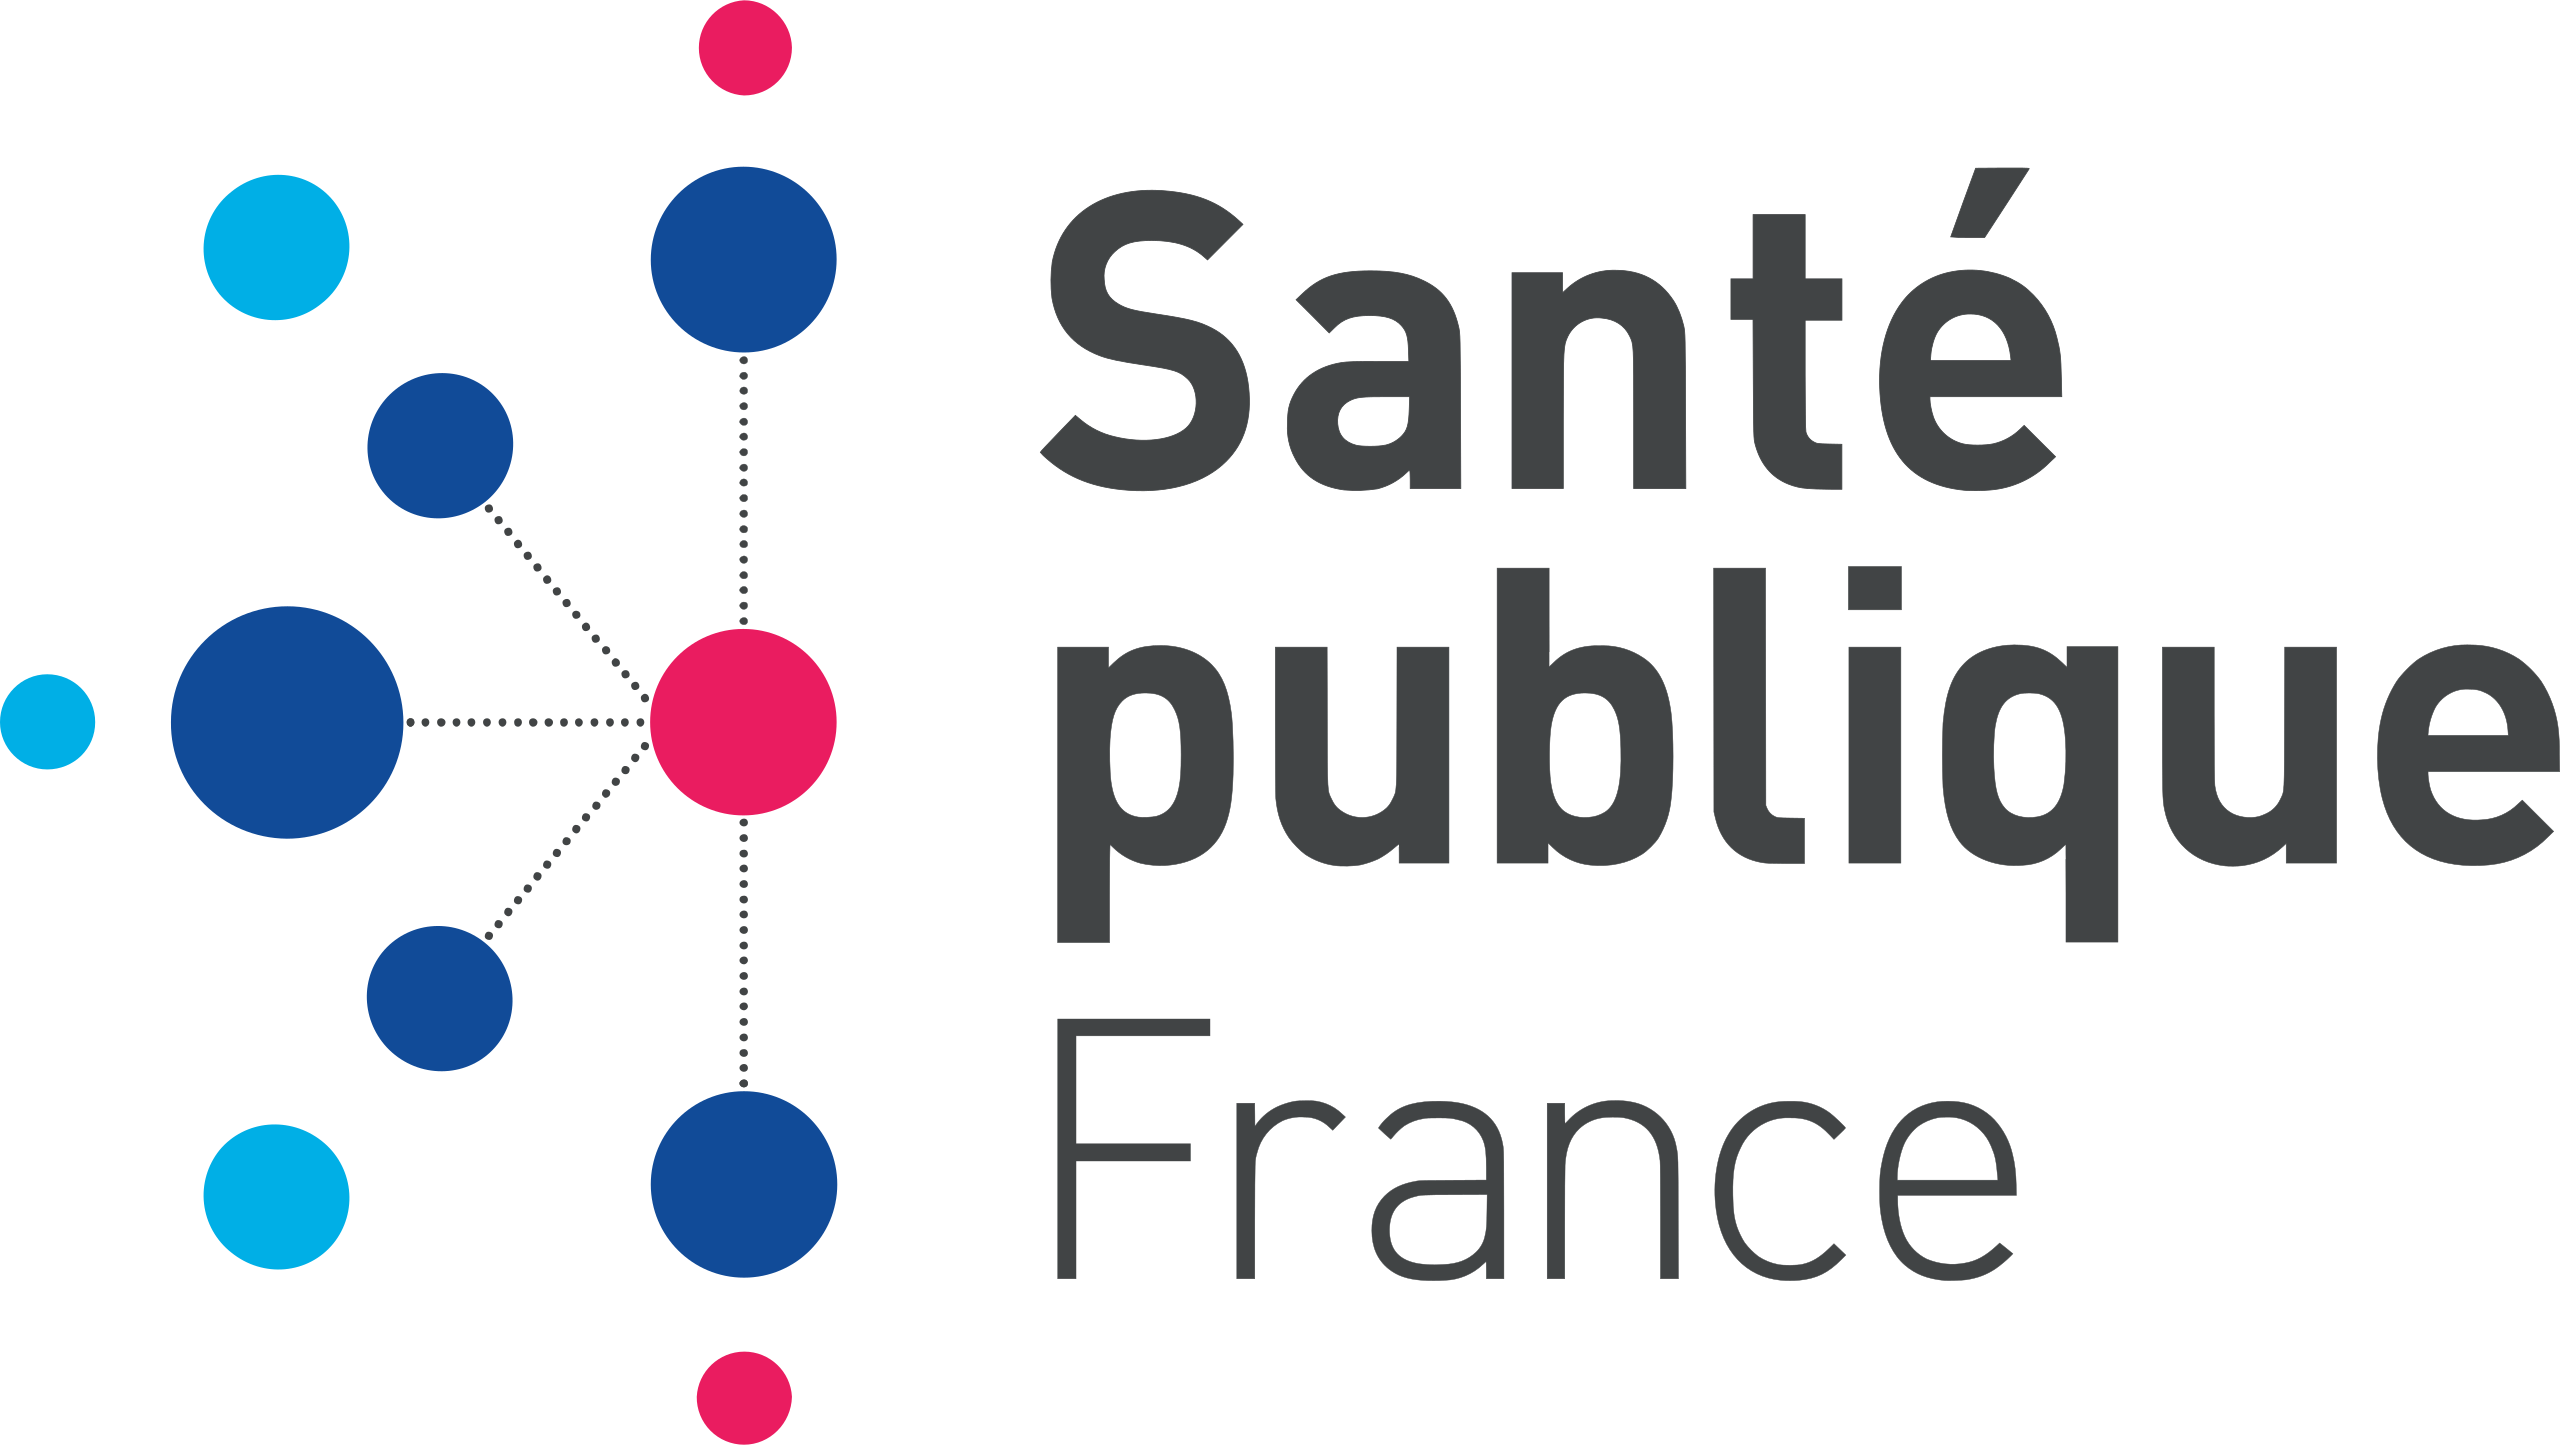



## 1. Introduction

L'agence Santé publique France souhaite améliorer sa base de données Open Food Facts qui permet de connaître la qualité nutritionnelle de leur produits.  
Ils souhaitent développer un système de suggestion ou d'auto-complétion pour remplir la base de données plus efficacement.

Mon rôle est de déterminer la faisabilité de cette application en analysant ces données et en produisants des graphiques compréhensible à tous.

**Données d'entrée**:
- [Tous les produits](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip)
- [Description de toutes les colonnes](https://world.openfoodfacts.org/data/data-fields.txt)

**Données de sortie**: 
- Rapport d'exploration
- Conclusion sur la faisabilité de l'application.

<!---
Critères d'évaluation:
- Vous avez défini les objectifs de son nettoyage de données en fonction de la problématique métier
- Vous avez défini sa démarche de préparation et nettoyage des données
-->

---
En regardant la description des colonnes, je remarque que le fichier ne contient aucune donnée qui entrerait en conflit avec les 5 principes du RGPD (Règlement Général sur la Protection des Données):
- **Le principe de finalité** : le responsable d'un fichier ne peut enregistrer et utiliser des informations sur des personnes physiques que dans un but bien précis, légal et légitime ;
- **Le principe de proportionnalité et de pertinence** : les informations enregistrées doivent être pertinentes et strictement nécessaires au regard de la finalité du fichier ;
- **Le principe d'une durée de conservation limitée** : il n'est pas possible de conserver des informations sur des personnes physiques dans un fichier pour une durée indéfinie. Une durée de conservation précise doit être fixée, en fonction du type d'information enregistrée et de la finalité du fichier ;
- **Le principe de sécurité et de confidentialité** : le responsable du fichier doit garantir la sécurité des informations qu'il détient. Il doit en particulier veiller à ce que seules les personnes autorisées aient accès à ces informations ;
- **Les droits des personnes**.

Tout en continuant de regarder la description, je remarque que je peux tenter de déterminer la faisabilité de suggérer les valeurs pour 3 types:
- La catégorie du produit
- Le nutri-score du produit
- Les valeur nutritionnelles d'un produit

### 1.1 Importation des données

Afin de lire, nettoyer, analyser et visualiser les données, j'impote les librairies suivantes:

In [1]:
import os.path 
import pandas as pd
import numpy as np
import math  
import random

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer  
from sklearn.model_selection import GridSearchCV  
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn import linear_model
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import scale, LabelEncoder
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud  
from collections import Counter  

import warnings  
warnings.filterwarnings('ignore')

# Allow pandas to display all columns when displaying a table
pd.set_option("display.max_columns", None)

product_csv_path = '../input/fr.openfoodfacts.org.products.csv'
products = pd.read_csv(product_csv_path, sep='\t', low_memory=False)
products.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,NaN,NaN,28 g (1 ONZ),NaN,0.0,[ bananas -> en:bananas ]

J'observe les nombre de lignes et colonnes

In [2]:
products.shape

(320772, 162)

## 2. Nettoyage & Analyse

### 2.1 Analyse des valeurs manquantes

Je commence par observer mon jeu de donnée et les valeurs manquantes

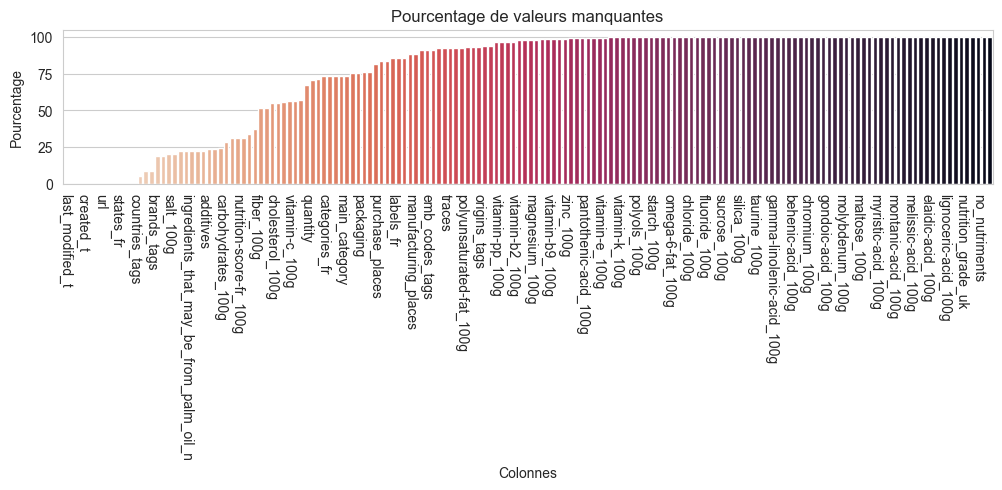

In [3]:
def create_percentage_missing_chart(df, xticksRange):
    # Get the missing data in percentage
    missing_data = df.isna().mean() * 100

    # Sort by value asc
    missing_data = missing_data.sort_values()

    # Create the figure
    plt.figure(figsize=(12, 2))

    ## Add horizontal lines
    sns.set_style('whitegrid')

    ## Set a color palette (https://seaborn.pydata.org/tutorial/color_palettes.html)
    colors = sns.color_palette("rocket_r", len(missing_data))

    ## Create the barplot
    sns.barplot(x=missing_data.index, y=missing_data,  palette=colors) # Create the bar plot

    ## Rotate the x labels and only one out of three for better readability
    plt.xticks(rotation=-90)
    plt.xticks(range(0, len(missing_data.index), xticksRange))

    ## Set the labels
    plt.ylabel('Pourcentage')
    plt.xlabel('Colonnes')
    plt.title('Pourcentage de valeurs manquantes')
    plt.show()

def create_color_palette(values, thresholds, colors):  
    """Create a color palette based on the given thresholds and colors."""  
    color_palette = []  
    for value in values:  
        for i in range(len(thresholds)):  
            if value < thresholds[i]:  
                color_palette.append(colors[i])  
                break  
        else:  
            color_palette.append(colors[-1])  
    return color_palette

def display_graph_missing_data(df, figsize_height):
    # Calculate the missing value percentage and count for each column  
    missing_data = df.isna().mean() * 100  
    missing_count = df.isna().sum()  
    unique_count = df.nunique()
    # Create a DataFrame to store the missing value percentage and count  
    missing_df = pd.DataFrame({"Missing Percentage": missing_data, "Missing Count": missing_count, "Unique Count": unique_count})  

    # Sort the DataFrame by missing percentage in descending order  
    missing_df = missing_df.sort_values(by="Missing Percentage", ascending=False)  
    thresholds = [25, 50, 75, 100]  
    colors = ["#4fff87", "#4fc4ff", "#ffbc4f", "#ff4f4f"]  

    # Map the colors based on the percentage value  

    color_palette = create_color_palette(missing_df["Missing Percentage"], thresholds, colors)  

    plt.figure(figsize=(10, figsize_height)) # Adjust the figure size as per your preference  
    ax = sns.barplot(x="Missing Percentage", y=missing_df.index, data=missing_df, palette=color_palette) # Create a horizontal bar plot  

    # Add labels and legend to the plot  
    plt.xlabel("Valeurs manquantes en %")  
    plt.ylabel("Colonnes")  
    plt.title("Pourcentage de valeurs manquantes")  

    # Add the count of missing values inside each bar  
    # for i, (value, name) in enumerate(zip(missing_df["Missing Count"], missing_df.index)):  
    #     ax.text(1, i, f" {value} ", va="center")  
    for i, (missing_value, unique_value, name) in enumerate(  
        zip(missing_df["Missing Count"], missing_df["Unique Count"], missing_df.index)  
    ):
        ax.text(1, i, f"Missing: {missing_value}", va="center")
        ax.text(20, i, f"Unique: {unique_value}", va="center")
    # Create a custom legend  
    legend_labels = [f"{thresholds[i]-25}-{thresholds[i+1]-25}%" if i != len(thresholds)-1 else f"{thresholds[i]-25}+%" for i in range(len(thresholds))]  
    colors_scaled = [plt.cm.colors.to_rgb(color) for color in colors]  
    legend_elements = [plt.Line2D([0], [0], marker="s", color="white", markerfacecolor=colors_scaled[i], markersize=10) for i in range(len(colors))]  
    plt.legend(legend_elements, legend_labels, loc="lower right")
    
    # Display the plot  
    plt.show()
    
create_percentage_missing_chart(products, 3)

Graphiquement, on remarque qu'il y a un bon nombre de colonnes avec beaucoup de valeurs manquantes.  
Le but de l'application étant de suggérer les valeurs pour un produit, je décide de prendre en compte toutes les colonnes qui ont moins de 90% de valeurs manquantes.

Avant cela, je fais une bref observation en chiffres

In [4]:
missing_values = products.isna().mean() * 100
columns_below_or_equal_90_percent = missing_values[missing_values <= 90]
columns_between_50_and_90_percent = missing_values[(missing_values >= 50) & (missing_values <= 90)]
columns_below_50_percent = missing_values[missing_values < 50]

columns_above_90_percent = missing_values[missing_values > 90]  

print(f"Sur {len(products.columns)} colonnes, il y a:\n")
print(f"- {len(columns_below_or_equal_90_percent)} colonnes qui ont moins de 90% de valeurs manquantes")
print(f"---- {len(columns_between_50_and_90_percent)} colonnes ont plus de 50% de valeurs manquantes")
print(f"---- {len(columns_below_50_percent)} colonnes ont moins de 50% de valeurs manquantes")
      
print(f"\n- {len(columns_above_90_percent)} colonnes on plus de 90% de valeurs manquantes")

Sur 162 colonnes, il y a:

- 62 colonnes qui ont moins de 90% de valeurs manquantes
---- 28 colonnes ont plus de 50% de valeurs manquantes
---- 34 colonnes ont moins de 50% de valeurs manquantes

- 100 colonnes on plus de 90% de valeurs manquantes


Je vais donc conserver ici 62 colonnes uniquement

In [5]:
products_below_90_percent = products[columns_below_or_equal_90_percent.index] 
products_below_90_percent.shape

(320772, 62)

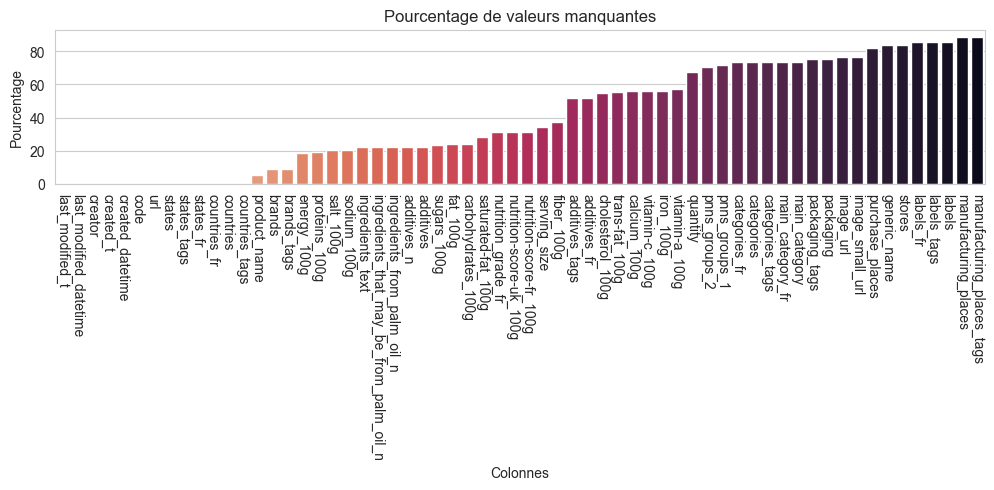

In [6]:
create_percentage_missing_chart(products_below_90_percent, 1)

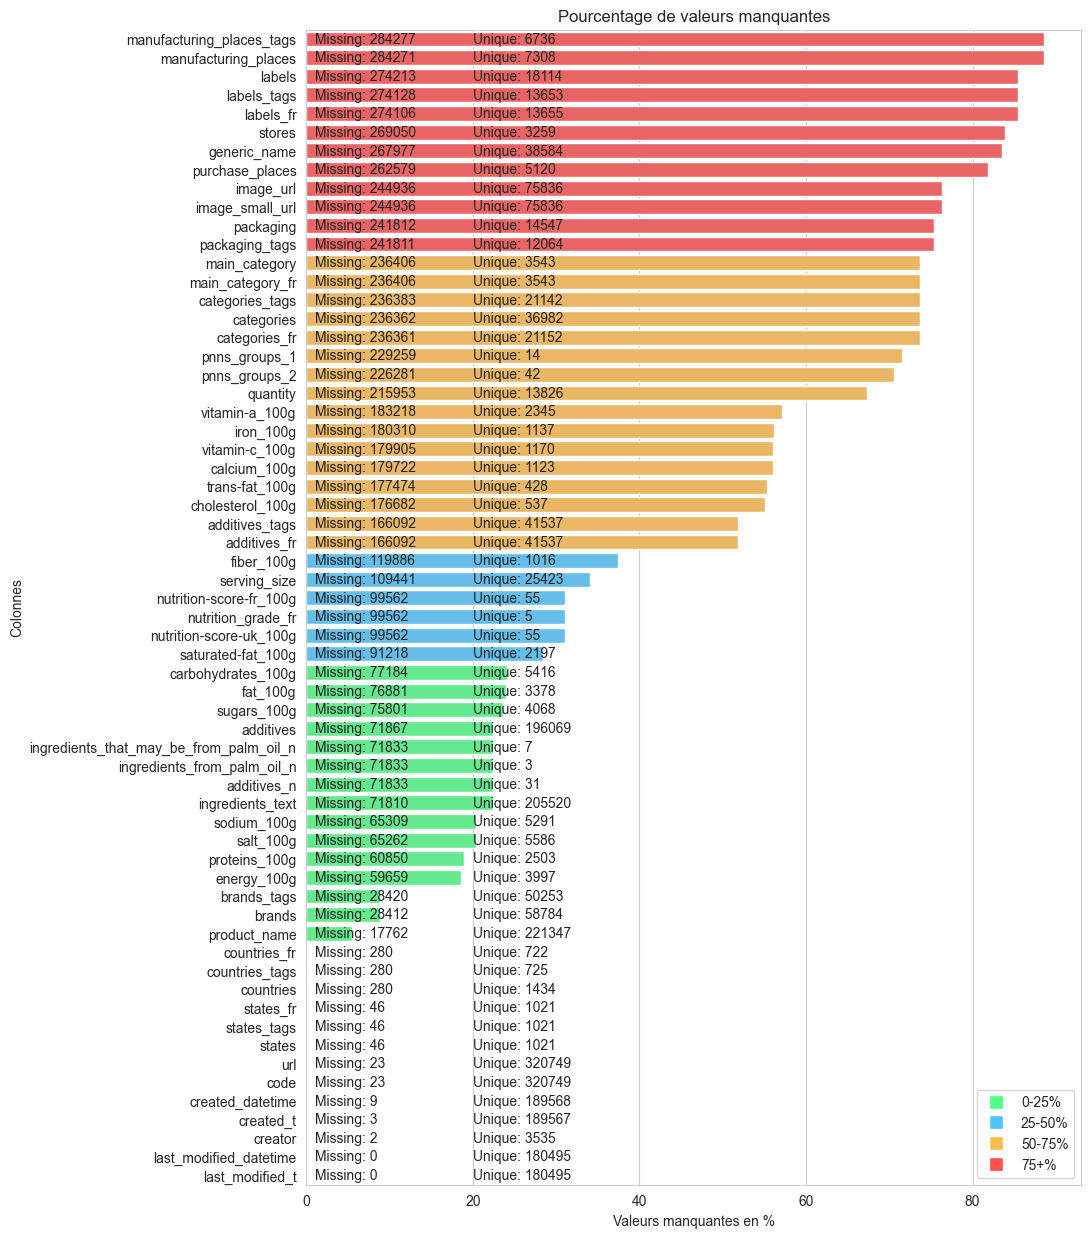

In [7]:
display_graph_missing_data(products_below_90_percent, 15)

Je fais un pré-tri des colonnes que je trouve inutiles de conserver pour l'application.  
Principalement des colonnes qualitatives qui ont beaucoup de valeurs uniques et manquantes ou qui n'ont pas d'intérêt (ex: created_t)

In [8]:
delete_useless_columns = [    
    "manufacturing_places_tags",
    "manufacturing_places",
    "labels",
    "labels_tags",
    "labels_fr",
    "stores",
    "generic_name",
    "purchase_places",
    "image_url",
    "image_small_url",
    "packaging",
    "packaging_tags",
    "main_category",
    "categories_tags",
    "categories",
    "categories_fr",
    "pnns_groups_1",
    "pnns_groups_2",
    "quantity",
    "additives_tags",
    "additives_fr",
    "additives",
    "serving_size",
    "ingredients_text",
    "brands_tags",
    "brands",
    "countries",
    "countries_tags",
    "states_fr",
    "states",
    "states_tags",
    "url",
    "created_datetime",
    "created_t",
    "creator",
    "last_modified_datetime",
    "last_modified_t",
    "ingredients_that_may_be_from_palm_oil_n",
    "nutrition-score-uk_100g",
]

products_pre_clean = products_below_90_percent.drop(columns=delete_useless_columns)  

In [9]:
products_pre_clean.shape

(320772, 23)

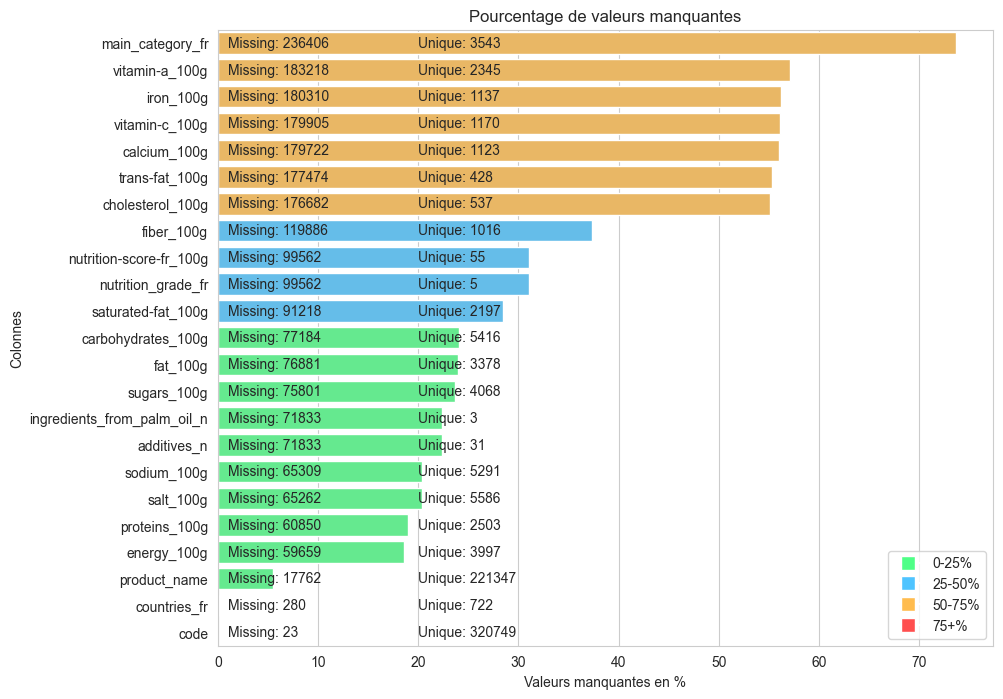

In [10]:
display_graph_missing_data(products_pre_clean, 8)

Il me reste donc 23 colonnes à nettoyer & analyser.  
Observons le type de ces colonnes:

In [11]:
pd.set_option('display.max_rows', None)  
# Create a DataFrame containing the data types  
data_types_table = pd.DataFrame(products_pre_clean.dtypes, columns=['Data Type'])  
# Display the table  
data_types_table

,Data Type
code,object
product_name,object
countries_fr,object
additives_n,float64
ingredients_from_palm_oil_n,float64
nutrition_grade_fr,object
main_category_fr,object
energy_100g,float64
fat_100g,float64
saturated-fat_100g,float64


Les types des colonnes me paraît correct.

### 2.2 Suppression des doublons

Je vérifie si il y a des doublons sur la colonne "code" uniquement et je les supprimes.
Également pour tous les produits qui n'ont pas de code et qui ne sont pas identifiables.

In [12]:
pd.set_option('display.max_rows', 5)  

print(f"Suppression de {products_pre_clean['code'].duplicated().sum()} doublons")
products_pre_clean.drop_duplicates(subset='code', keep='first', inplace=True)

print(f'Suppression de {len(products_pre_clean[products_pre_clean["code"].isna()])} produits sans code')
products_pre_clean = products_pre_clean[~products_pre_clean["code"].isna()]

Suppression de 22 doublons
Suppression de 1 produits sans code


### 2.3 Analyses des valeurs qualitatives

Je vais maintenant faire une première approche de mes colonnes qualitatives.

#### 2.3.1 product_name

In [13]:
print(f"Il y a {products_pre_clean['product_name'].isna().sum()}/{(len(products_pre_clean))} valeurs sans nom de produits")
print(f"Il y a {len(products_pre_clean['product_name'].unique())} valeurs unique")

Il y a 17762/320749 valeurs sans nom de produits
Il y a 221344 valeurs unique


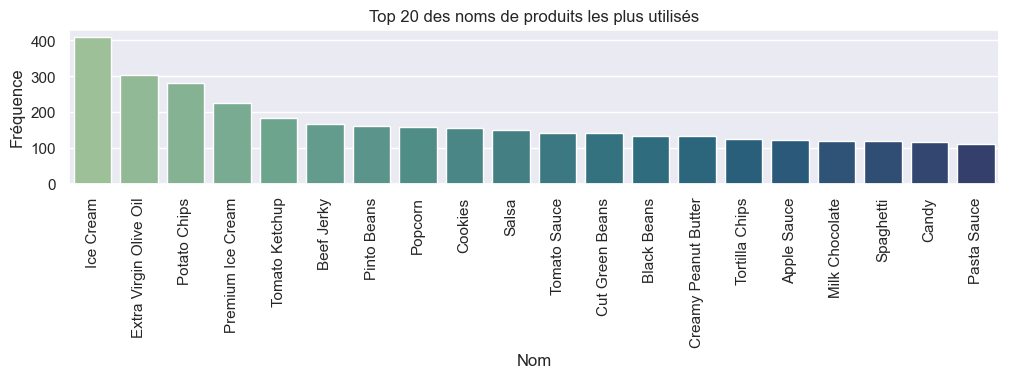

In [14]:
top_20_products = products_pre_clean['product_name'].value_counts().head(20)  
  
# Create a bar plot using Seaborn  
sns.set(style="darkgrid")  
plt.figure(figsize=(12, 2))  
sns.barplot(x=top_20_products.index, y=top_20_products.values, palette="crest")  
plt.xticks(rotation=90)  
plt.xlabel('Nom')  
plt.ylabel('Fréquence')  
plt.title('Top 20 des noms de produits les plus utilisés')  
plt.show()  

Je vois qu'il y a quelques produits qui ont des noms similaires sans grand écart.  
Je vais remplacer toutes les valeurs manquantes par "inconnu"

In [15]:
products_pre_clean["product_name"] = products_pre_clean["product_name"].fillna("inconnu")
print(f"Il reste {products_pre_clean['product_name'].isna().sum()} produit sans nom.")

Il reste 0 produit sans nom.


#### 2.3.2 countries_fr

In [16]:
print(f"Il y a {products_pre_clean['countries_fr'].isna().sum()}/{(len(products_pre_clean))} valeurs sans pays")
print(f"Il y a {len(products_pre_clean['countries_fr'].unique())} valeurs unique")

Il y a 280/320749 valeurs sans pays
Il y a 718 valeurs unique


Pour 280 valeurs, je préfère les supprimer car il n'affecterons pas le dataset

In [17]:
products_pre_clean.dropna(subset=['countries_fr'], inplace=True)  
print(f"Il y a {products_pre_clean['countries_fr'].isna().sum()} valeurs sans pays")

Il y a 0 valeurs sans pays


J'examine rapidement le dataset

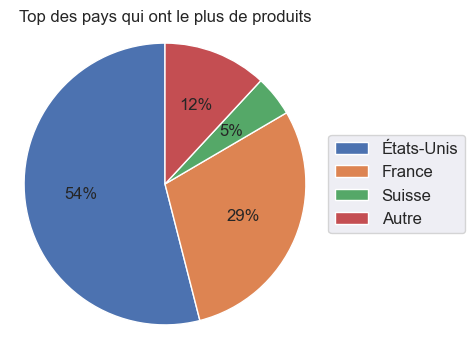

In [18]:
top_3_countries = products_pre_clean['countries_fr'].value_counts().head(3)  
  
# Calculate the sum of values of all other countries  
other_countries_count = products_pre_clean['countries_fr'].value_counts().iloc[3:].sum()  

# Add a new value for the sum of remaining countries to the top 3 countries series  
top_3_countries['Autre'] = other_countries_count  
  
# Create a pie chart  
plt.figure(figsize=(4, 4))  
patches, texts, _ = plt.pie(top_3_countries.values, startangle=90, autopct='%1.f%%')  
  
# Update the labels to include "Others"  
labels = top_3_countries.index.map(lambda x: x if x != "Others" else f"Others ({other_countries_count})")  
plt.legend(patches, labels, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)  
  
plt.title('Top des pays qui ont le plus de produits')  
plt.axis('equal')  
  
plt.show()

On remarque que les États-Unis et la France représente 83% des produits à eux deux.

#### 2.3.3 nutrition_grade_fr	

In [19]:
print(f"Il y a {products_pre_clean['nutrition_grade_fr'].isna().sum()}/{(len(products_pre_clean))} valeurs sans grade de nutrition")
print(f"Il y a {len(products_pre_clean['nutrition_grade_fr'].unique())} valeurs unique")

Il y a 99316/320469 valeurs sans grade de nutrition
Il y a 6 valeurs unique


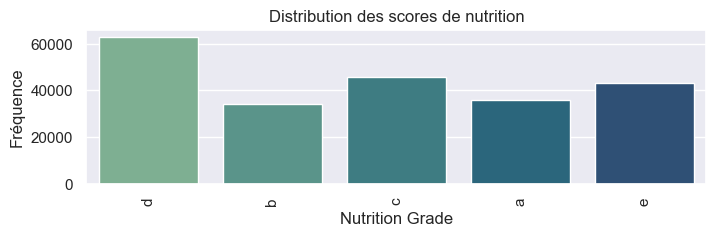

In [20]:
# Create a histogram using Seaborn  
sns.set(style="darkgrid")  
plt.figure(figsize=(8, 2))  
sns.countplot(x=products_pre_clean['nutrition_grade_fr'], palette="crest")  
plt.xlabel('Nutrition Grade')  
plt.ylabel('Fréquence')  
plt.title('Distribution des scores de nutrition')  
plt.xticks(rotation=90)  
plt.show()

In [21]:
products_pre_clean['nutrition_grade_fr'].value_counts()

nutrition_grade_fr
d    62746
c    45528
e    43018
a    35625
b    34236
Name: count, dtype: int64

Les grades des produits sont assez similaires, les grades D et C sont en tête de classement.

#### 2.3.4 main_category_fr

In [22]:
print(f"Il y a {products_pre_clean['main_category_fr'].isna().sum()}/{(len(products_pre_clean))} valeurs sans catégories")
print(f"Il y a {len(products_pre_clean['main_category_fr'].unique())} valeurs unique")

Il y a 236207/320469 valeurs sans catégories
Il y a 3533 valeurs unique


Beaucoup de valeurs unique, ça peut être plus compliqué à prédire, je vais supprimer toutes les categories contenant ":" car même si j'ai sélectionner main_category_fr, je remarque que j'ai également des catégories encore en anglais, italien, ...

Je les remplace par NA et sauvegarde le tout dans une nouvelle colonne que je nommerai category_fr_clean si je souhaite par la suite comparer.
Dans la colonne original, je vais remplacer les valeurs null par "inconnu"

In [23]:
count_colon = products_pre_clean['main_category_fr'].str.contains(':').sum()  
print(f"Il y a {count_colon} catégories qui ne sont pas français")
products_pre_clean['category_fr_clean'] = products_pre_clean['main_category_fr']
products_pre_clean['category_fr_clean'] = np.where(products_pre_clean['main_category_fr'].str.contains(':'), None, products_pre_clean['main_category_fr'])  

products_pre_clean["main_category_fr"] = products_pre_clean["main_category_fr"].fillna("inconnu")

print(f"Il y a {len(products_pre_clean['category_fr_clean'].unique())} valeurs unique")

Il y a 2896 catégories qui ne sont pas français
Il y a 1494 valeurs unique


Je regarde le top des catégories

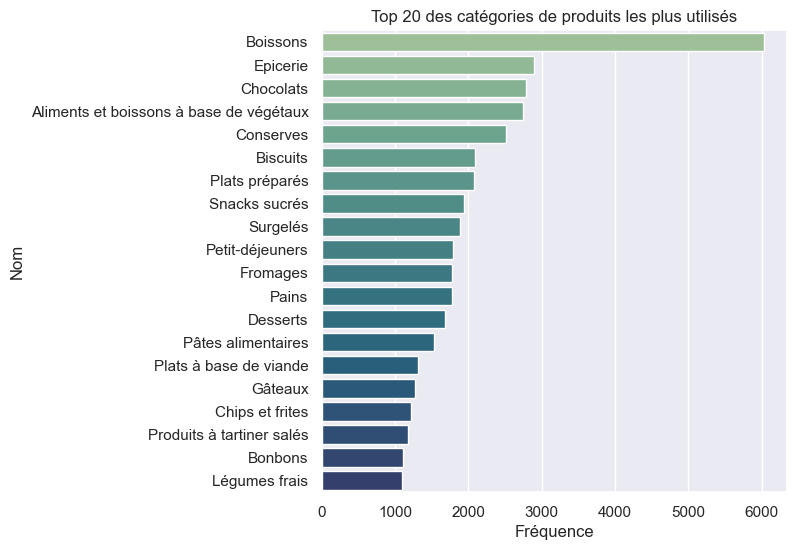

In [24]:
top_20_cat = products_pre_clean['category_fr_clean'].value_counts().head(20)  
sns.set(style="darkgrid")  
plt.figure(figsize=(6, 6))  
sns.barplot(x=top_20_cat.values, y=top_20_cat.index, palette="crest")  
plt.xlabel('Fréquence')  
plt.ylabel('Nom')  
plt.title('Top 20 des catégories de produits les plus utilisés')  
plt.show()

Avec 1494 valeurs unique et quelques catégories qui sont réutilisé +1000 fois, je vais surement pouvoir suggérer des catégories par la suite.

Je regarde les 100 catégories les plus utilisés en France et aux États-Unis.

In [25]:
def create_wordcloud(data, country, ax):  
    # Filter the data by the specified country  
    filtered_data = data[data['countries_fr'] == country]  
    filtered_data = filtered_data[filtered_data['category_fr_clean'].notna()]  

    # Count the occurrence of each category  
    categories_count = Counter(filtered_data['category_fr_clean'])
    top_categories = dict(categories_count.most_common(100))  

    # Create a word cloud  
    wordcloud = WordCloud(width=600, height=400, random_state=21, max_font_size=110, background_color='#f1f1f1').generate_from_frequencies(top_categories)  

    ax.imshow(wordcloud, interpolation="bilinear")  
    ax.axis('off')  
    ax.imshow(wordcloud, interpolation="bilinear")  
    ax.set_title(f"Catégories les plus fortes - {country}")
    # plt.show()

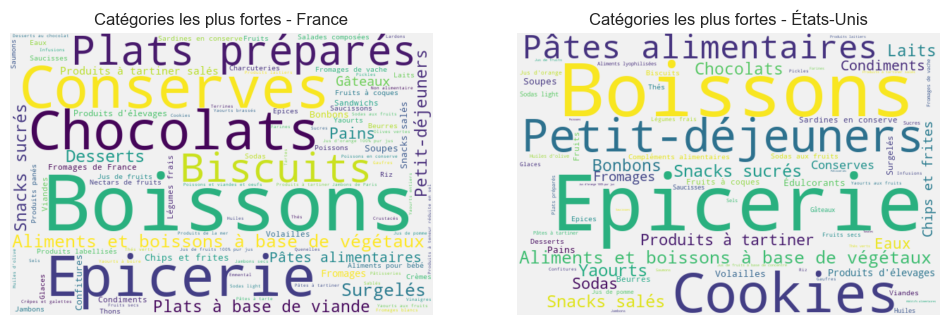

In [26]:
# Create subplots with a 1x2 grid layout  
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  
  
create_wordcloud(products_pre_clean, 'France', axs[0])
create_wordcloud(products_pre_clean, 'États-Unis', axs[1])

### 2.4 Analyses des valeurs quantitatives

#### 2.4.1 additives_n

In [27]:
print(f"Il y a {products_pre_clean['additives_n'].isna().sum()}/{(len(products_pre_clean))} valeurs sans nb d'additifs")
print(f"Il y a {len(products_pre_clean['additives_n'].unique())} valeurs unique")

Il y a 71616/320469 valeurs sans nb d'additifs
Il y a 32 valeurs unique


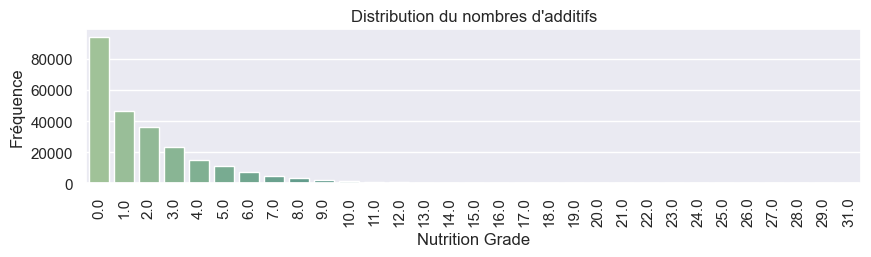

In [28]:
# Create a histogram using Seaborn  
sns.set(style="darkgrid")  
plt.figure(figsize=(10, 2))  
sns.countplot(x=products_pre_clean['additives_n'], palette="crest")  
plt.xlabel('Nutrition Grade')  
plt.ylabel('Fréquence')  
plt.title('Distribution du nombres d\'additifs')  
plt.xticks(rotation=90)  
plt.show()

Pour le nombre d'additif, je vais remplacer les valeurs manquantes par 0.

In [29]:
products_pre_clean['additives_n'] = products_pre_clean['additives_n'].fillna(0)
print(f"Il y a {products_pre_clean['additives_n'].isna().sum()}/{(len(products_pre_clean))} valeurs sans nb d'additifs")

Il y a 0/320469 valeurs sans nb d'additifs


#### 2.4.2 ingredients_from_palm_oil_n

In [30]:
print(f"Il y a {products_pre_clean['ingredients_from_palm_oil_n'].isna().sum()}/{(len(products_pre_clean))} valeurs sans nutri score")
print(f"Il y a {len(products_pre_clean['ingredients_from_palm_oil_n'].unique())} valeurs unique")

Il y a 71616/320469 valeurs sans nutri score
Il y a 4 valeurs unique


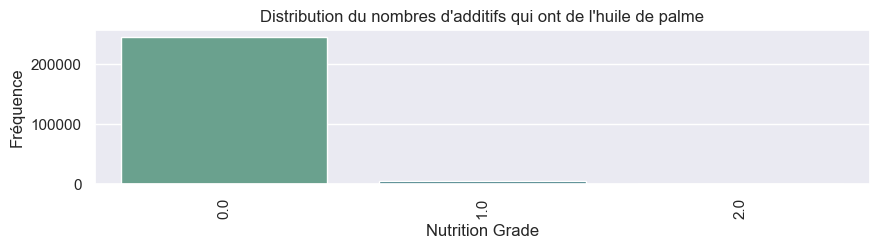

In [31]:
# Create a histogram using Seaborn  
sns.set(style="darkgrid")  
plt.figure(figsize=(10, 2))  
sns.countplot(x=products_pre_clean['ingredients_from_palm_oil_n'], palette="crest")  
plt.xlabel('Nutrition Grade')  
plt.ylabel('Fréquence')  
plt.title('Distribution du nombres d\'additifs qui ont de l\'huile de palme')  
plt.xticks(rotation=90)  
plt.show()

La plupart sont à 0, j'ai pas vraiment besoin de cette colonne. Je la supprime complètement.

In [32]:
products_pre_clean = products_pre_clean.drop(columns=["ingredients_from_palm_oil_n"])
products_pre_clean.shape

(320469, 23)

#### 2.4.3 nutrition-score-fr_100g

In [33]:
print(f"Il y a {products_pre_clean['nutrition-score-fr_100g'].isna().sum()}/{(len(products_pre_clean))} valeurs sans nutri score")
print(f"Il y a {len(products_pre_clean['nutrition-score-fr_100g'].unique())} valeurs unique")

Il y a 99316/320469 valeurs sans nutri score
Il y a 56 valeurs unique


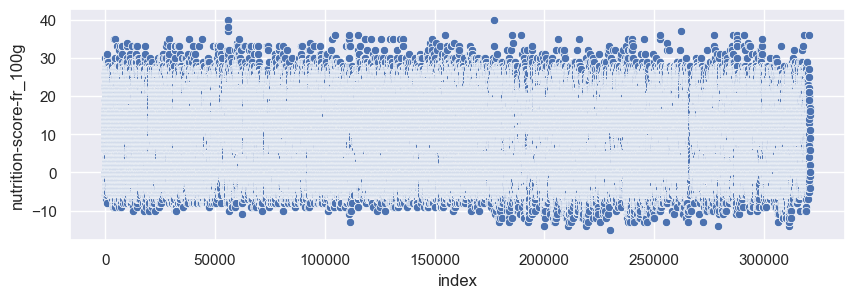

In [34]:
# Reset index for the dataframe
prds = products_pre_clean.copy().reset_index()  
# Create scatter plot using seaborn
plt.figure(figsize=(10, 3))
sns.scatterplot(data=prds,x='index', y='nutrition-score-fr_100g')

# Show the plot  
plt.show()

[Wikipedia](https://fr.wikipedia.org/wiki/Nutri-score#:~:text=Le%20Nutri%2Dscore%20est%20un,nutritionnelle%20d'un%20produit%20alimentaire.) indique que le score varie entre -15 et +40.

- A = -15 jusqu'a -2
- B = -1 à +3
- C = +4 à +11
- D = +12 à +16
- E = +17 à +40

Je vérifie les outliers même si le graphique à l'air de ne pas en avoir

In [35]:
above_40 = products_pre_clean['nutrition-score-fr_100g'] > 40
below_minus_15 = products_pre_clean['nutrition-score-fr_100g'] < -15
len(products_pre_clean[above_40 | below_minus_15])

0

Est-ce que j'ai des nutri-grade qui n'ont pas de nutri-score et vice-versa ?

In [36]:
  # Count the number of rows with missing values  
missing_value_grade = products_pre_clean['nutrition_grade_fr'].isnull().sum()
missing_value_score = products_pre_clean['nutrition-score-fr_100g'].isnull().sum()

missing_value_both = len(products_pre_clean[(products_pre_clean['nutrition_grade_fr'].isnull()) | (products_pre_clean['nutrition-score-fr_100g'].isnull())])

print(f"Nutrition grade a {missing_value_grade} valeurs manquantes")
print(f"Nutrition score a {missing_value_score} valeurs manquantes")
print(f"Nutrition score et grade manquantes réunis = {missing_value_both}")

missing_value_rows = products_pre_clean[products_pre_clean['nutrition_grade_fr'].isnull() != products_pre_clean['nutrition-score-fr_100g'].isnull()]  
  
missing_value_rows_count = len(missing_value_rows)  
print(f"\nIls ont {missing_value_rows_count} différence de ligne (dans le cas où on a le même nombre de valeurs manquantes sur des lignes différentes)")

Nutrition grade a 99316 valeurs manquantes
Nutrition score a 99316 valeurs manquantes
Nutrition score et grade manquantes réunis = 99316

Ils ont 0 différence de ligne (dans le cas où on a le même nombre de valeurs manquantes sur des lignes différentes)


Je vais vérifier si j'ai une cohérence entre le nutri-grade et le nutri score avec les conditions de wikipedia.

In [37]:
# Filter the dataframe based on the conditions  
grade_a = products_pre_clean.loc[(products_pre_clean['nutrition-score-fr_100g'] >= -15) & (products_pre_clean['nutrition-score-fr_100g'] <= -2)]
grade_b = products_pre_clean.loc[(products_pre_clean['nutrition-score-fr_100g'] >= -1) & (products_pre_clean['nutrition-score-fr_100g'] <= 3)]  
grade_c = products_pre_clean.loc[(products_pre_clean['nutrition-score-fr_100g'] >= 4) & (products_pre_clean['nutrition-score-fr_100g'] <= 11)]  
grade_d = products_pre_clean.loc[(products_pre_clean['nutrition-score-fr_100g'] >= 12) & (products_pre_clean['nutrition-score-fr_100g'] <= 16)]  
grade_e = products_pre_clean.loc[(products_pre_clean['nutrition-score-fr_100g'] >= 17) & (products_pre_clean['nutrition-score-fr_100g'] <= 40)]  

# Count the correct and incorrect values
grade_lvls = ['a', 'b', 'c', 'd', 'e']
grade_numbers = [grade_a, grade_b, grade_c, grade_d, grade_e]
for grade_lvl, grade_number in zip(grade_lvls, grade_numbers):
    actual_grade_nb = products_pre_clean['nutrition_grade_fr'].isin([grade_lvl]).sum()
    correct_grade_nb = len(grade_number)
    print(f"Grade {grade_lvl} à {actual_grade_nb} valeurs et devrait en avoir {correct_grade_nb}")

# test = products_pre_clean.loc[(products_pre_clean['nutrition-score-fr_100g'] >= -15) & (products_pre_clean['nutrition-score-fr_100g'] >= -2) & (products_pre_clean['nutrition_grade_fr'] == "a")]
# len(test)
# pd.set_option('display.max_colwidth', None)  

# print(products[products["code"] == "0000000018524"].url)
# print(products[products["code"] == "0000000031172"].url)
# print(products[products["code"] == "0000000038348"].url)
# print(products[products["code"] == "0000000069601"].url)
# print(products[products["code"] == "0000236555909"].url)

Grade a à 35625 valeurs et devrait en avoir 26895
Grade b à 34236 valeurs et devrait en avoir 51282
Grade c à 45528 valeurs et devrait en avoir 46952
Grade d à 62746 valeurs et devrait en avoir 42942
Grade e à 43018 valeurs et devrait en avoir 53082


En regardant les urls des nutri score de A en trop, je remarque que la donnée que j'ai sur le site et via le dataset diffères.
J'ai des produits qui sont indiqués en B ou D sur le site et en A dans le dataset fourni.

On pourrait très bien corrigé tous les nutri-score en utilisant les conditions mais je ne suis pas un expert du domaine et je ne suis pas sur. Le nutri score est différent comparé au donnée reel vs dataset, je préfère ne pas remplacer les nutri-score actuels, je modifierai trop de données et risque de rendre inutilisable ce dataset.

Néamoins je vais pouvoir tenter de les suggérer plus bas dans ce notebook.

Pour récapituler, en valeurs manquantes, il me reste:

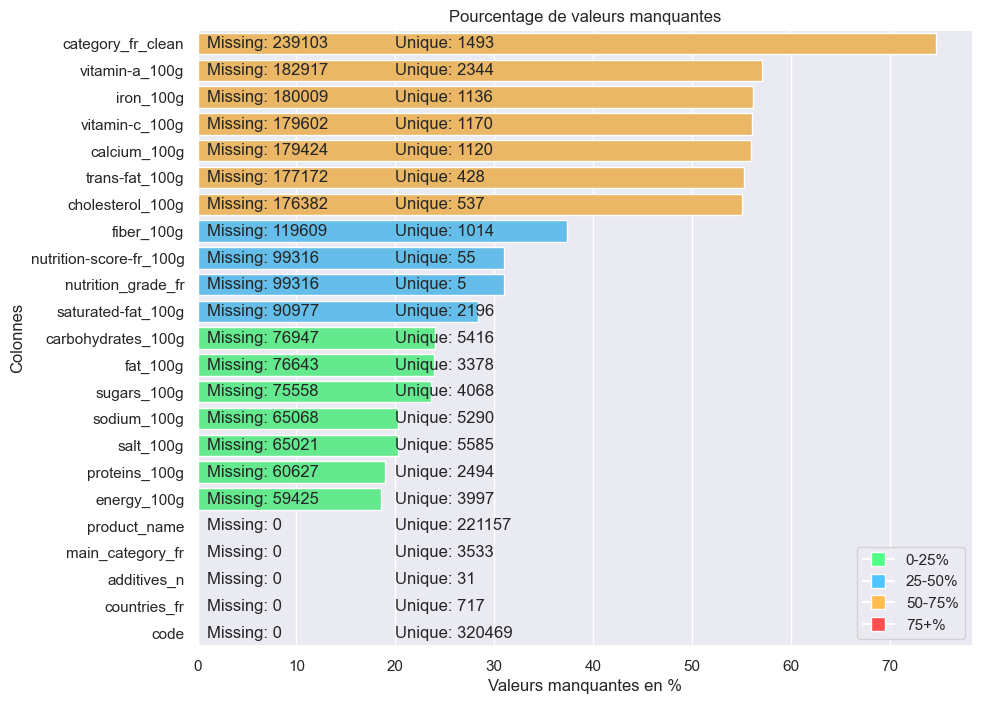

In [38]:
display_graph_missing_data(products_pre_clean, 8)

#### 2.4.4 *_100g

Maintenant je vais analyser les colonnes qui finissent toutes par _100g (sauf le nutri score)

In [39]:
def get_pre_clean_100g():
    df = products_pre_clean.filter(like='_100g')
    df.drop(columns=["nutrition-score-fr_100g"], inplace=True)
    return df

products_pre_clean_100g = get_pre_clean_100g()
products_pre_clean_100g.shape

(320469, 15)

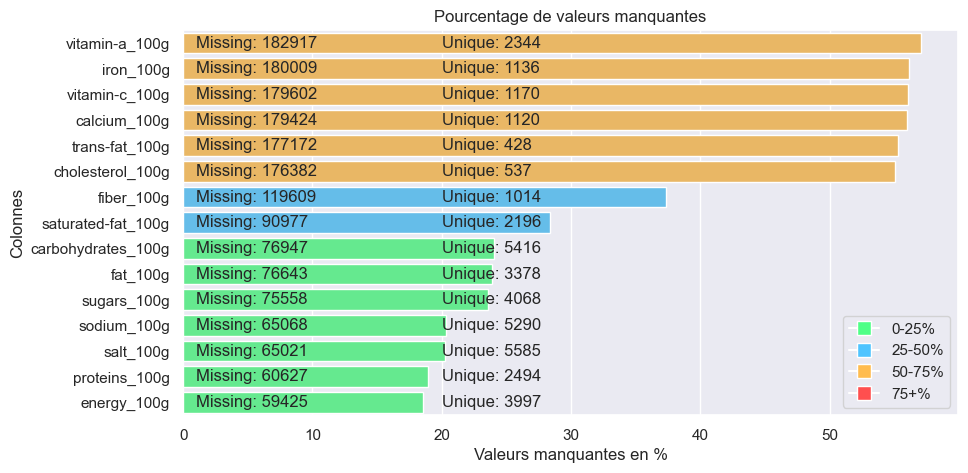

In [40]:
display_graph_missing_data(products_pre_clean_100g, 5)

In [41]:
pd.set_option('display.max_rows', None)
products_pre_clean_100g.describe()

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g
count,2.610440e+05,243826.000000,229492.000000,143297.000000,144087.000000,243522.000000,244911.000000,200860.000000,259842.000000,255448.000000,255401.000000,137552.000000,140867.000000,141045.000000,140460.000000
mean,1.141907e+03,12.729408,5.129214,0.073476,0.020072,32.074089,16.003266,2.861799,7.076115,2.028865,0.798910,0.000202,0.023367,0.124603,0.003516
std,6.447992e+03,17.577832,8.011420,1.540228,0.358065,29.732372,22.327519,12.868096,8.409178,128.285013,50.510555,0.013682,2.236451,3.313444,0.208202
min,0.000000e+00,0.000000,0.000000,-3.570000,0.000000,0.000000,-17.860000,-6.700000,-800.000000,0.000000,0.000000,-0.000340,-0.002100,0.000000,-0.000260
25%,3.770000e+02,0.000000,0.000000,0.000000,0.000000,6.000000,1.300000,0.000000,0.700000,0.063500,0.025000,0.000000,0.000000,0.000000,0.000000
50%,1.100000e+03,5.000000,1.790000,0.000000,0.000000,20.600000,5.710000,1.500000,4.760000,0.581660,0.229000,0.000000,0.000000,0.035000,0.001010
75%,1.674000e+03,20.000000,7.140000,0.000000,0.020000,58.330000,24.000000,3.600000,10.000000,1.374140,0.541000,0.000107,0.003700,0.106000,0.002400
max,3.251373e+06,714.290000,550.000000,369.000000,95.238000,2916.670000,3520.000000,5380.000000,430.000000,64312.800000,25320.000000,5.000000,716.981100,694.737000,50.000000


La moyenne reste en général entre 0 et 100 à par pour la colonne energy_100g.

La documentation explique qu'il devrait il y avoir trois colonnes energie (g, kJ et kcal).
Ici je n'en ai qu'une qui a des valeurs moyennant 1140.

D'après https://nutritionaustralia.org/fact-sheets/balancing-energy-in-and-energy-out/:

100gr d'énergie c'est au maximum 3770 kJ. (_Fat – 37.7kJ per gram_)  
3770 kJ = 901 kcal.

Étant donné que 50% on des valeurs supérieur à 1100, je continue en prenant en compte que la colonne energy_100g est en kJ.
Je ne peux pas convertir en gramme car je n'ai pas toutes les informations du produit.  
Je vais donc supprimer toute les valeurs > 3770 et inférieur à 0 et je renomme la colonne.  

Pour les autres colonnes, je supprime toutes les valeurs > 100 et < 0.

In [42]:
products_pre_clean.rename(columns={"energy_100g":"energy_kJ"}, inplace=True)

# Get the updated 100g columns
products_pre_clean_100g = get_pre_clean_100g()

In [43]:
pd.set_option('display.max_rows', 10)
# Energy
energy_above_3770 = (products_pre_clean[["energy_kJ"]] > 3770).any(axis=1)
energy_below_0 = (products_pre_clean[["energy_kJ"]] < 0).any(axis=1)
print(f"Suppression de {len(products_pre_clean[energy_above_3770 + energy_below_0])} produits > 3770kJ")
products_pre_clean = products_pre_clean[~(energy_above_3770 + energy_below_0)]

Suppression de 360 produits > 3770kJ


In [44]:
for i, col in enumerate(products_pre_clean_100g.columns):
    above_100g =  (products_pre_clean[[col]] > 100).any(axis=1)
    below_0g =  (products_pre_clean[[col]] < 0).any(axis=1)

    print(f"Suppression de {len(products_pre_clean[above_100g + below_0g])} produits > 100gr ({col})")
    products_pre_clean = products_pre_clean[~(above_100g + below_0g)]


Suppression de 2 produits > 100gr (fat_100g)
Suppression de 0 produits > 100gr (saturated-fat_100g)
Suppression de 9 produits > 100gr (trans-fat_100g)
Suppression de 0 produits > 100gr (cholesterol_100g)
Suppression de 17 produits > 100gr (carbohydrates_100g)
Suppression de 7 produits > 100gr (sugars_100g)
Suppression de 3 produits > 100gr (fiber_100g)
Suppression de 3 produits > 100gr (proteins_100g)
Suppression de 157 produits > 100gr (salt_100g)
Suppression de 0 produits > 100gr (sodium_100g)
Suppression de 1 produits > 100gr (vitamin-a_100g)
Suppression de 4 produits > 100gr (vitamin-c_100g)
Suppression de 10 produits > 100gr (calcium_100g)
Suppression de 1 produits > 100gr (iron_100g)


<Axes: >

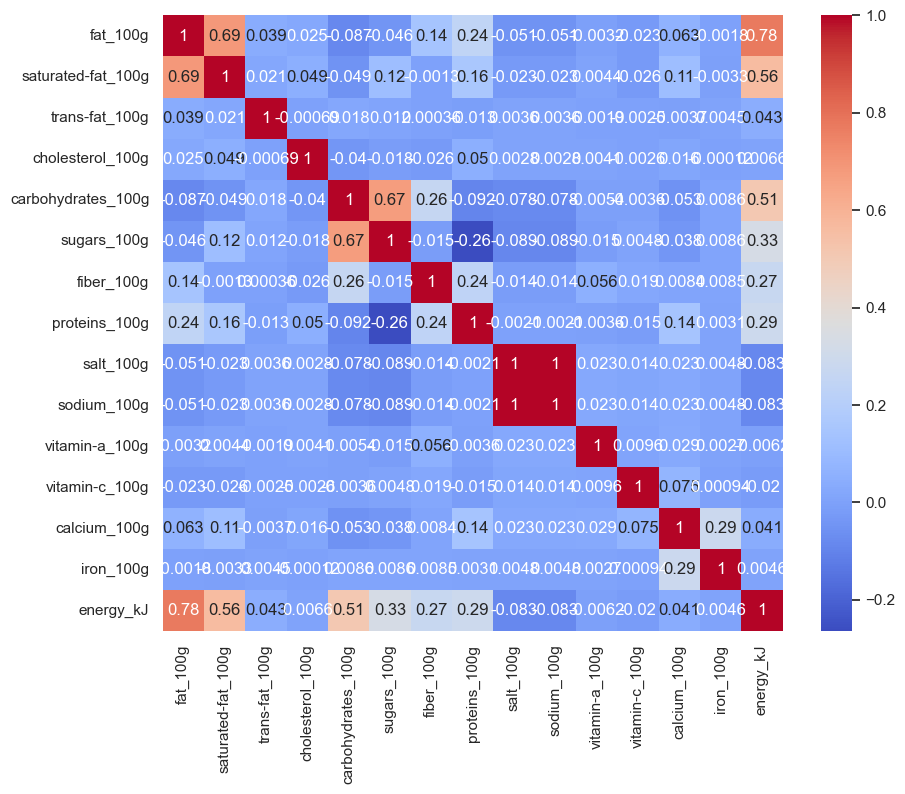

In [45]:
# Calculate the correlation matrix  
correlation_matrix = products_pre_clean[products_pre_clean_100g.columns.tolist() + ["energy_kJ"]].corr()  
  
# Create a heatmap using seaborn  
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')  

Comme sodium et salt sont très corrélé, je vais garder qu'une seul colonne et les merger entre elles pour réduire le nombre de valeurs manquantes.

In [46]:
nb_missing_value_salt = products_pre_clean["salt_100g"].isna().sum()
nb_missing_value_sodium = products_pre_clean["sodium_100g"].isna().sum()

print(f"Salt valeurs manquantes: {nb_missing_value_salt}")
print(f"Sodium valeurs manquantes: {nb_missing_value_sodium}")

missing_value_rows = products_pre_clean[products_pre_clean['salt_100g'].isnull() != products_pre_clean['sodium_100g'].isnull()]  
  
missing_value_rows_count = len(missing_value_rows)  
print(f"\nIls ont {missing_value_rows_count} différences de lignes (dans le cas où on a le même nombre de valeurs manquantes sur des lignes différentes)")

products_pre_clean['salt_100g'].fillna(products_pre_clean['sodium_100g'], inplace=True)
products_pre_clean.drop(columns=["sodium_100g"], inplace=True)
print(f"Salt valeurs manquantes: {nb_missing_value_salt}")

Salt valeurs manquantes: 65006
Sodium valeurs manquantes: 65053

Ils ont 47 différences de lignes (dans le cas où on a le même nombre de valeurs manquantes sur des lignes différentes)
Salt valeurs manquantes: 65006


Le merge n'a pas servi dans notre cas, mais c'est intéressant de voir que les colonnes étaient presque toutes similaires.

In [47]:
# Get the updated 100g columns
products_pre_clean_100g = get_pre_clean_100g()

products_100g = products_pre_clean[products_pre_clean_100g.columns]
products_100g.shape

(319895, 13)

#### 2.5 Remplacement des valeurs manquantes

#### 2.5.1 Remplacement des valeurs manquantes pour les columns *_100g

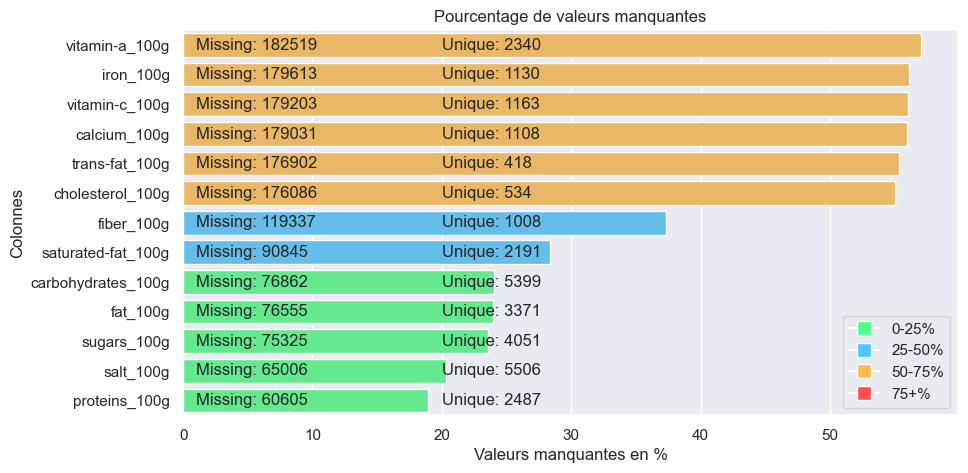

In [48]:
display_graph_missing_data(products_pre_clean_100g, 5)

Je pourrais me dire que les valeurs non rempli par défaut sont remplacé par 0. 
Dans le but de les remplir le plus correctement possible, je vais utiliser le modèle KNN et évaluer différent paramètre de voisin afin d'utiliser celui le plus adapté.

Je vais créer un deuxième tableau qui prendra en compte les valeurs non manquantes pour tester la précision du KNN

In [49]:
# products_clean_100g = products_pre_clean_100g.dropna().sample(5000)
products_clean_100g = products_pre_clean_100g.dropna()

print("Avec missing data",products_pre_clean_100g.shape)
print("Sans missing data",products_clean_100g.shape)

Avec missing data (319895, 13)
Sans missing data (5000, 13)


Je vais créer un clone de mon tableau products_clean_100g dans lequel je vais retirer 30% de valeurs manquante pour évaluer la précision des modèles utilisé pour remplir les valeurs manquantes.

In [50]:
# Create a copy of the array
products_clean_100g_with_nans = products_clean_100g.copy()

# Set the desired percentage of missing value  
percent_of_missing_values = 0.3  
  
# Create a mask with the desired percentage of missing values  
mask = np.random.uniform(size=products_clean_100g_with_nans.shape) < percent_of_missing_values  
  
# Set the selected values to NaN  
products_clean_100g_with_nans[mask] = np.nan

In [51]:
products_clean_100g_with_nans.isna().mean() * 100

fat_100g              29.62
saturated-fat_100g    30.52
trans-fat_100g        31.48
cholesterol_100g      29.82
carbohydrates_100g    31.58
                      ...  
salt_100g             29.14
vitamin-a_100g        28.80
vitamin-c_100g        30.24
calcium_100g          30.24
iron_100g             30.42
Length: 13, dtype: float64

J'ai donc 3 tableau:
- **products_pre_clean_100g**: Contient toutes les valeurs
- **products_clean_100g**: Contient toutes les valeurs non manquantes
- **products_clean_100g_with_nans**: Replica de products_clean_100g avec 30% de valeurs manquantes imputés.

Utilisation du KNN

In [52]:
%%time
X_train, X_test, y_train, y_test = train_test_split(products_clean_100g_with_nans, products_clean_100g, test_size=0.2, random_state=42)

def knn_imputer_test(n_neighbors):
    # Create and fit the KNN Imputer model  
    imputer = KNNImputer(n_neighbors=n_neighbors)  
    imputed_X_train = imputer.fit_transform(X_train)
    imputed_X_test = imputer.transform(X_test)
    # Calculate the RMSE between imputed values and original non-missing values  
    rmse_test = np.sqrt(mean_squared_error(imputed_X_test, y_test))
    rmse_train = np.sqrt(mean_squared_error(imputed_X_train, y_train))
    
    return (rmse_test,rmse_train,imputer)

CPU times: user 6.25 ms, sys: 1.06 ms, total: 7.31 ms
Wall time: 1.87 ms


In [53]:
%%time
n_neighbors_list = list(range(1, 25, 5))

accuracy_knns = pd.DataFrame(columns=['neighbors',"RMSE Test", 'RMSE Train', 'Imputer'])

for n in n_neighbors_list:
    (rmse_test, rmse_train, imputer) = knn_imputer_test(n)
    accuracy_knns.loc[len(accuracy_knns)] = [n, rmse_test, rmse_train, imputer]

CPU times: user 22.1 s, sys: 4.64 s, total: 26.7 s
Wall time: 5.93 s


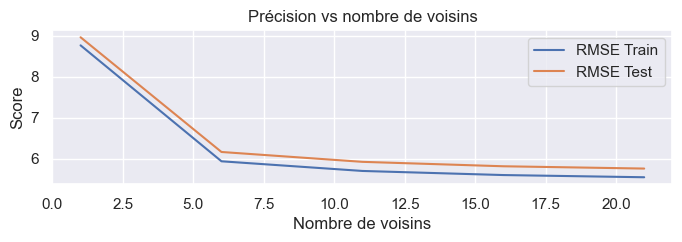

In [54]:
# Create a line plot  
plt.figure(figsize=(8, 2)) # Set the figure size with desired height and width  

sns.lineplot(data=accuracy_knns, x='neighbors', y='RMSE Train', label='RMSE Train')  
sns.lineplot(data=accuracy_knns, x='neighbors', y='RMSE Test', label='RMSE Test')  

# Set labels and title  
plt.xlabel('Nombre de voisins')  
plt.ylabel('Score')  
plt.title('Précision vs nombre de voisins')
plt.legend()
# Display the plot  
plt.show()

Je vais remplacer les valeurs manquantes par KNN en utilisant 11 voisins.

In [55]:
(rmse_test, rmse_train, imputer) = knn_imputer_test(11)

In [56]:
products_pre_clean[products_clean_100g.columns].isna().sum()

fat_100g               76555
saturated-fat_100g     90845
trans-fat_100g        176902
cholesterol_100g      176086
carbohydrates_100g     76862
                       ...  
salt_100g              65006
vitamin-a_100g        182519
vitamin-c_100g        179203
calcium_100g          179031
iron_100g             179613
Length: 13, dtype: int64

In [57]:
transformed_values = imputer.transform(products_pre_clean_100g)
products_pre_clean.loc[:, products_clean_100g.columns] = transformed_values

J'avais fait des test en ajoutant energy_kJ au KNN et mon score RMSE était aux alentours de 95 en moyenne, on va l'imputer différement par la suite.  
On regarde ce qu'il nous reste:

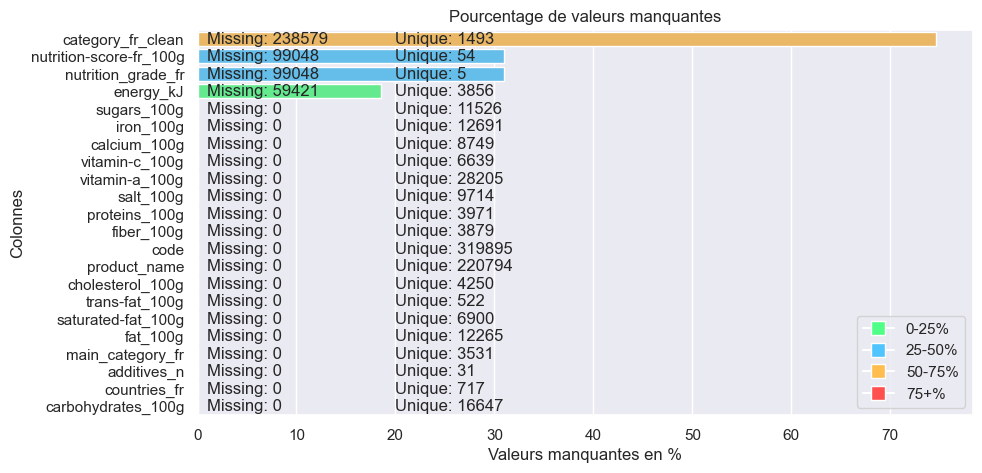

In [58]:
display_graph_missing_data(products_pre_clean, 5)

#### 2.5.2 Remplacer les valeurs manquantes du nutriscore et de l'energie

In [59]:
# test2 = products_pre_clean.filter(like='_100g')
# regression = test2.copy()

# # Todo > test with and without and see score.
# regression = regression.dropna()

# X = regression.drop(columns=['nutrition-score-fr_100g'])
# y = regression['nutrition-score-fr_100g']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# reg = LinearRegression().fit(X_train, y_train)
# reg_score = reg.score(X_test, y_test)
# y_pred = reg.predict(X_test)  


# rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))  
# rmse_train = np.sqrt(mean_squared_error(y_train, y_train)) 
# print(rmse_train, rmse_test)

In [60]:
%%time
# Select all column ending by _100g
products_pre_clean_filtered = products_pre_clean.filter(like='_100g')

# Adding the energy_kJ column
products_pre_clean_filtered = products_pre_clean_filtered.assign(energy_kJ=products_pre_clean['energy_kJ'])  

# Prepare the regression array
regression = products_pre_clean_filtered.copy()
regression = regression.fillna(0)

def get_training_data(column):
     # Set X & y
    X = regression.drop(columns=[column])
    y = regression[column]
    
    # Split train & test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    # Scale X train & X test to normalize the data
    X_train_scaled = scale(X_train)
    X_test_scaled = scale(X_test)

    return (X_train_scaled, X_test_scaled, y_train, y_test)

def test_model_performance(column):

    (X_train_scaled, X_test_scaled, y_train, y_test) = get_training_data(column)
    
    n_split_list = list(range(5, 6, 1))
    # Changing the split list of the KFold doesn't change the score, I keep it for recording
    # n_split_list = list(range(5, 25, 5))

    for n in n_split_list:
         # Prepare a cross validation score by splitting in multiple dataset
        cv = KFold(n_splits=n, shuffle=True, random_state=42)
        
        # Create the linear regression
        lin_reg = LinearRegression().fit(X_train_scaled, y_train)
        # Train the linear regression on all the splitted data and get the RMSE
        lr_score_train = -1 * cross_val_score(lin_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
        lr_score_test = mean_squared_error(y_test, lin_reg.predict(X_test_scaled), squared=False)

        # Lasso Regression (should remove overfitting)
        lasso_reg = LassoCV().fit(X_train_scaled, y_train)
        lasso_score_train = -1 * cross_val_score(lasso_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
        lasso_score_test = mean_squared_error(y_test, lasso_reg.predict(X_test_scaled), squared=False)
        
        # Ridge Regression  (should remove overfitting)
        ridge_reg = RidgeCV().fit(X_train_scaled, y_train)
        ridge_score_train = -1 * cross_val_score(ridge_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
        ridge_score_test = mean_squared_error(y_test, ridge_reg.predict(X_test_scaled), squared=False)

        # RandomForest
        # When testing with RandomForest, I test with a single parameter configuration that suits me,
        # I could go further by testing different hyperparameter settings but that is not the objective of this project (ex: GridSearchCV)
        regr = RandomForestRegressor(n_estimators=50,max_depth=5, random_state=0)
        
        regr.fit(X_train_scaled, y_train)    
        y_pred = regr.predict(X_test_scaled)
        
        # Calculate the root mean squared error (RMSE) on the training data  
        rf_score_train = np.sqrt(mean_squared_error(y_train, regr.predict(X_train_scaled)))  
        # Calculate the root mean squared error (RMSE) on the test data  
        rf_score_test = np.sqrt(mean_squared_error(y_test, y_pred))  
        
        scores = pd.DataFrame(columns=['RMSE Train', 'RMSE Test'])
        scores.loc['Linear Regression', :] = [lr_score_train, lr_score_test]
        scores.loc['Lasso Regression', :] = [lasso_score_train, lasso_score_test]
        scores.loc['Ridge Regression', :] = [ridge_score_train, ridge_score_test]
        scores.loc['RandomForest', :] = [rf_score_train, rf_score_test]

        # Not using the loop here, so we return directly
        return (scores, regr)
    # return (lr_score_train, lr_score_test)

(scores_nutrition, regr_nutrition_score) = test_model_performance('nutrition-score-fr_100g')
(scores_energy, _) = test_model_performance('energy_kJ')

print("\nnutrition-score-fr_100g")
print(scores_nutrition)

print("\nenergy_kJ")
print(scores_energy)


nutrition-score-fr_100g
                  RMSE Train RMSE Test
Linear Regression   6.613262  5.772751
Lasso Regression     5.82391  5.788324
Ridge Regression    6.593428   5.77275
RandomForest         3.81364  4.053493

energy_kJ
                   RMSE Train   RMSE Test
Linear Regression  542.375219  450.053216
Lasso Regression   453.081285  450.345001
Ridge Regression   540.245986  450.053279
RandomForest       259.563871  566.144802
CPU times: user 2min 6s, sys: 6.27 s, total: 2min 12s
Wall time: 44.6 s


Random Forest étant le model qui performe le mieux pour le nutriscore, je vais donc l'utiliser pour remplacer les valeurs manquantes.
Et je vais remplacer les nutri grade par ceux correspondant en prenant en compte les critères wikipedia.

In [61]:
def replace_nutri_grade(score):  
    if score >= -15 and score <= -2:  
        return "a"  
    elif score > -1 and score <= 3:  
        return "b"  
    elif score > 4 and score <= 11:  
        return "c"  
    elif score > 11 and score <= 16:  
        return "d"  
    elif score > 16 and score <= 40:  
        return "e"  
    else:
        return np.nan

missing_nutriscore = products_pre_clean_filtered[products_pre_clean_filtered["nutrition-score-fr_100g"].isna()].drop(columns=["nutrition-score-fr_100g"]).fillna(0)

predicted_nutriscore = regr_nutrition_score.predict(missing_nutriscore)
predicted_nutriscore_series = pd.Series(predicted_nutriscore, index=missing_nutriscore.index)  
predicted_nutrisgrade = predicted_nutriscore_series.apply(replace_nutri_grade)  

products_pre_clean.loc[missing_nutriscore.index, "nutrition-score-fr_100g"] = predicted_nutriscore
products_pre_clean.loc[missing_nutriscore.index, "nutrition_grade_fr"] = predicted_nutrisgrade

Étant donné que energy_kJ n'est pas prédible avec les tests effectués,je vais remplacer les valeurs manquantes par la médiane

Je regarde la distribution de la colonne energy_kJ pour savoir par quoi remplacer les valeurs manquantes

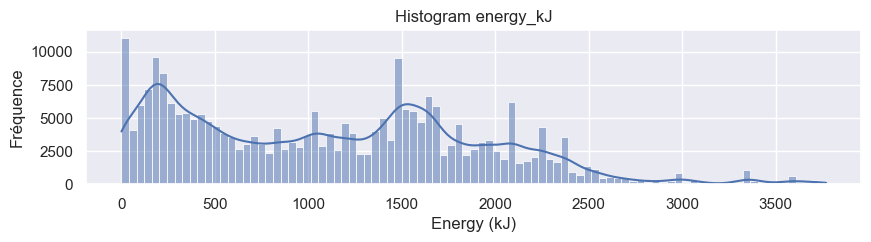

In [62]:
# Create a histogram  
plt.figure(figsize=(10,2))  
sns.histplot(data=products_pre_clean, x="energy_kJ", kde=True)  
plt.title("Histogram energy_kJ")  
plt.xlabel("Energy (kJ)")  
plt.ylabel("Fréquence")  
plt.show()

En l'occurence ici je vais utiliser la moyenne car la distribution n'a pas beaucoup d'outliers.

In [63]:
moy_energy_kJ = products_pre_clean["energy_kJ"].mean()  
products_pre_clean["energy_kJ"].fillna(moy_energy_kJ, inplace=True)  

Je suis curieux de voir la colonne qui influe le plus sur nutrition-score-fr_100g.

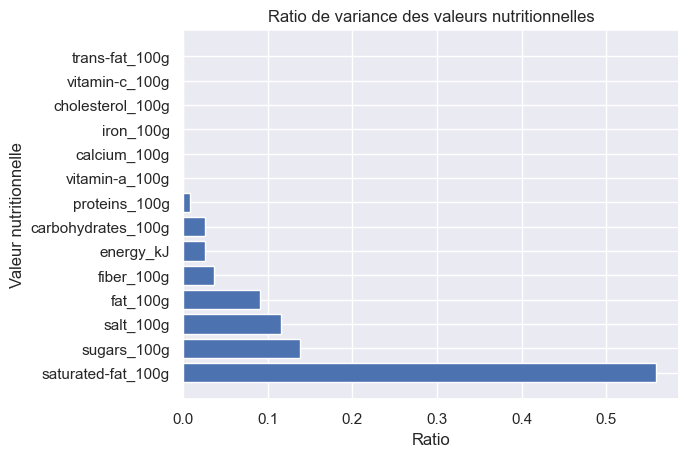

In [64]:
df_ratio = {'Colonne': list(products_pre_clean_filtered.drop(columns=["nutrition-score-fr_100g"]).columns),  
        'Ratio': regr_nutrition_score.feature_importances_}  

# create the dataframe  
df_ratio = pd.DataFrame(df_ratio)

df_ratio = df_ratio.sort_values(by='Ratio', ascending=False)  

# Creating the bar plot using matplotlib  
plt.barh(df_ratio['Colonne'], df_ratio['Ratio'])  
  
# Setting the title and labels  
plt.title('Ratio de variance des valeurs nutritionnelles')  
plt.xlabel('Ratio') 
plt.ylabel('Valeur nutritionnelle')  
  
# Adjusting the y-axis ticks for better visualization  
plt.yticks(range(len(df_ratio['Colonne'])), df_ratio['Colonne'])  
  
# Displaying the graph  
plt.show()  

On remarque alors que c'est le colonne saturated-fat_100g qui influe le plus sur le nutri-score

Je vais également effectuer une analyse en composante principal pour voir si on peut faire une réduction de dimensions

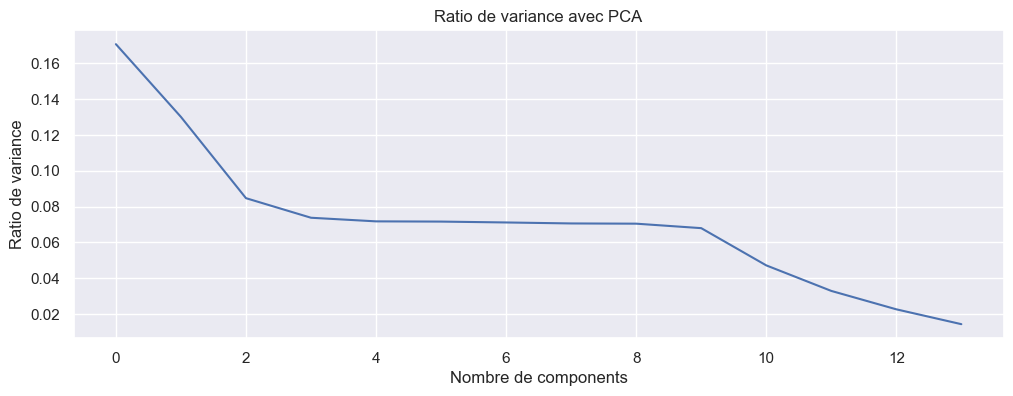

CPU times: user 1.56 s, sys: 250 ms, total: 1.81 s
Wall time: 347 ms


In [76]:
%%time
pca_model = PCA() # Without n_components parameters, it computes the features importance for every features in order.

(X_train_scaled, X_test_scaled, y_train, y_test) = get_training_data("nutrition-score-fr_100g")
X_train_pc = pca_model.fit_transform(X_train_scaled)

# View first 5 rows of all principal components
# pd.DataFrame(pca_model.components_.T).loc[:4,:]

explained_variance_ratio = pca_model.explained_variance_ratio_  

plt.figure(figsize=(12, 4))

sns.lineplot(x=range(len(explained_variance_ratio)), y=explained_variance_ratio)  
plt.xlabel('Nombre de components')  
plt.ylabel('Ratio de variance')  
plt.title('Ratio de variance avec PCA')  
plt.show()

On remarque que le nombre de composants pourrait se réduire.

In [91]:
best_pc_num_list = list(range(2, 13, 1))
    # Changing the split list of the KFold doesn't change the score, I keep it for recording
    # n_split_list = list(range(5, 25, 5))

accuracy_pc = pd.DataFrame(columns=['PC nb', 'RMSE Train',"RMSE Test"])

for n in best_pc_num_list:
    
    # Get cross-validation RMSE (train set)
    pcr_score_train = -1 * cross_val_score(lin_reg_pc, X_train_pc[:,:n], y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
    
    # Train model on training set
    lin_reg_pc = LinearRegression().fit(X_train_pc[:,:n], y_train)
    
    # Get first 9 principal components of test set
    X_test_pc = pca_model.transform(X_test_scaled)[:,:n]
    
    # Predict on test data
    preds = lin_reg_pc.predict(X_test_pc)
    preds_train = lin_reg_pc.predict(X_train_pc[:, : n])
    
    pcr_score_test = mean_squared_error(y_test, preds, squared=False)
    pcr_score_train = mean_squared_error(y_train, preds_train, squared=False)
    
    accuracy_pc.loc[len(accuracy_pc)] = [n, pcr_score_test, pcr_score_train]


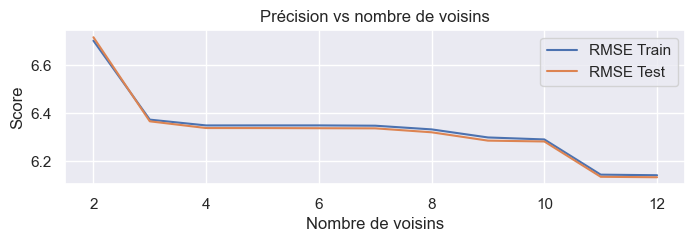

In [92]:
# Create a line plot  
plt.figure(figsize=(8, 2)) # Set the figure size with desired height and width  

sns.lineplot(data=accuracy_pc, x='PC nb', y='RMSE Train', label='RMSE Train')  
sns.lineplot(data=accuracy_pc, x='PC nb', y='RMSE Test', label='RMSE Test')  

# Set labels and title  
plt.xlabel('Nombre de voisins')  
plt.ylabel('Score')  
plt.title('Précision vs nombre de voisins')
plt.legend()
# Display the plot  
plt.show()

On obtiens un score superieur aux précedents modèles, le randomForest était très bien

Très bien, voyons ce qu'il nous reste:

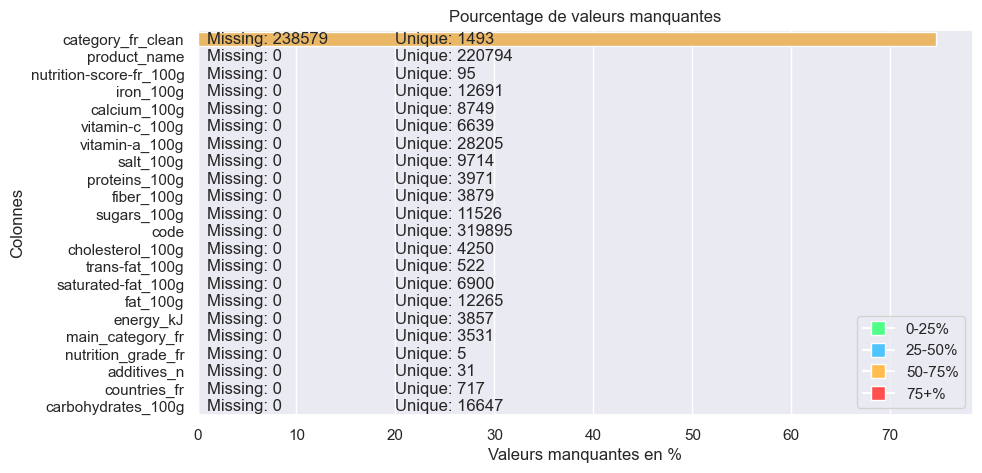

In [98]:
display_graph_missing_data(products_pre_clean, 5)

In [1]:
%%time

test_sample = products_pre_clean.dropna(subset=["category_fr_clean"])
# test_sample = products_pre_clean.dropna(subset=["category_fr_clean"]).sample(5000)

# 1. Drop the rows with missing values in the category_fr_clean column
# products_pre_clean_category = products_pre_clean.dropna(subset=["category_fr_clean"]).sample(5000)
products_pre_clean_category = test_sample.copy()

# 2. Select the specific numeric columns that I want to use for prediction and create a new DataFrame for training  
numeric_columns = products_pre_clean_filtered.columns
X = products_pre_clean_category[numeric_columns]  

# 3. Encode the category_fr_clean column as numeric labels  
label_encoder = LabelEncoder()  
y = label_encoder.fit_transform(products_pre_clean_category["category_fr_clean"])  

# 4. Split the dataset into training and testing sets  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  
  
# 5. Train the RandomForestClassifier model  
model = RandomForestClassifier()  
model.fit(X_train, y_train)  
  
# 6. Make predictions on the test set  
y_pred = model.predict(X_test)

# Edit the test sample to reflect the value
y_pred_all = model.predict(X)  
predicted_categories = label_encoder.inverse_transform(y_pred_all)  
test_sample["predicted_category"] = predicted_categories  
# test_sample["predicted_category"] = score...

# 7. Get the accuracy score of the model  
accuracy = accuracy_score(y_test, y_pred)
print("Précision:", accuracy)

test_sample[["category_fr_clean","main_category_fr","predicted_category"]]

NameError: name 'products_pre_clean' is not defined

Une précision de 52.8% est plutôt correct sachant qu'il y a +1400 valeurs.
Je vais l'utiliser pour remplacer les valeurs manquantes dans ce modèle.

In [95]:
# Predict missing value for all "category_fr_clean"
missing_data = products_pre_clean.loc[products_pre_clean["category_fr_clean"].isna(), numeric_columns]  
predicted_labels = model.predict(missing_data)

In [96]:
# Replace them all depending on score confidence
predicted_categories = label_encoder.inverse_transform(predicted_labels)
products_clean = products_pre_clean.copy()
products_clean.loc[products_clean["category_fr_clean"].isna(), "category_fr_clean"] = predicted_categories  

In [97]:
print(f"Total de valeur manquantes: {products_clean.isna().sum().sum()}")

Total de valeur manquantes: 0


In [112]:
test_anova = products_clean.groupby('category_fr_clean')[['energy_kJ']].mean().reset_index()
test_anova = test_anova.dropna()

label_encoder = LabelEncoder()
test_anova['category_fr_clean'] = label_encoder.fit_transform(test_anova['category_fr_clean'])

In [114]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
# from statsmodels.stats.anova import AnovaRM # Can renforce the model if it doesn't have enough data

model = ols('energy_kJ ~ category_fr_clean', data=test_anova).fit()

# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2) # type2 = default

# print(anova_table)
f_value = anova_table['F'][0]  
p_value = anova_table['PR(>F)'][0]  
  
print("F-value:", f_value)  
print("p-value:", p_value)

# Personal notes
# sum squared > différence entre observed value and group means
# df = degree of freedom (qty liberté dans le choix d'une valeur)
# F > indique si il y a une difference dans la moyenne des groups (ratio entre variabilité entre les groupes et la variabilité dans chaque groupe (residual))
# P value > Si je prends une décision je vois si j'ai une difference ou pas
# Test la null hyposete et non null.
# Si la pvalue est < 0.05 (parametre alpha qui par defaut est de 0.05) on rejette l'hypotese null et il y a difference entre les groupes

# Dans les categories, les moyennes sont différentes

F-value: 4.086397739882746
p-value: 0.043408037863307


P value étant inférieur à 0.05, on peut en conclure qu'il y a bien une différence entre les groupes.
Mais vérifions si on rajoute le pays

In [115]:
test_anova = products_clean.groupby('category_fr_clean')[['energy_kJ']].mean().reset_index()
test_anova = test_anova.dropna()

label_encoder = LabelEncoder()
test_anova['category_fr_clean'] = label_encoder.fit_transform(test_anova['category_fr_clean'])

In [116]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
# from statsmodels.stats.anova import AnovaRM # Can renforce the model if it doesn't have enough data

test_anova = products_clean.groupby(['category_fr_clean', "countries_fr"])[['energy_kJ']].mean().reset_index()
test_anova['check_countries'] = test_anova['countries_fr'].apply(lambda x: False if len(x.split(',')) > 1 else True)
test_anova = test_anova[test_anova['check_countries'] == True]
test_anova = test_anova.drop(columns=["check_countries"])
test_anova = test_anova.dropna()

label_encoder = LabelEncoder()
test_anova['category_fr_clean'] = label_encoder.fit_transform(test_anova['category_fr_clean'])
test_anova['countries_fr'] = label_encoder.fit_transform(test_anova['countries_fr'])

model = ols('energy_kJ ~ category_fr_clean + countries_fr + category_fr_clean * countries_fr', data=test_anova).fit()
# category_fr_clean * countries_fr = pair wise interaction sur le terme (controller l'effet du pays sur la categorie)
# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2) # type2 = default

print(anova_table)
# Dans les categories, les moyennes sont différentes
# Y a pas vraiment de difference entre les categories par pays.

                                      sum_sq      df          F        PR(>F)
category_fr_clean               3.332078e+07     1.0  87.247809  1.607593e-20
countries_fr                    1.526272e+05     1.0   0.399642  5.273132e-01
category_fr_clean:countries_fr  4.468705e+05     1.0   1.170095  2.794523e-01
Residual                        1.412302e+09  3698.0        NaN           NaN


On remarque qu'il n'y a pas vraiment de différence entre les catégories de produits et l'énergie.